In [ ]:
!nvidia-smi

Sat Dec 25 01:26:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    175MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import *
from warnings import filterwarnings
filterwarnings('ignore')
from tensorflow.keras.utils import Sequence
import random

import glob
from IPython.display import display

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle_3m/infor_image.csv')

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(1417, 3)
(251, 3)
(295, 3)


In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
smooth=100

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
IMAGE_SIZE = (256, 256)

In [ ]:
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

def ResUnet(input):
  X_input = Input(input) #iniating tensor of input shape

  # Stage 1
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
  conv_1 = BatchNormalization()(conv_1)
  conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
  conv_1 = BatchNormalization()(conv_1)
  pool_1 = MaxPool2D((2,2))(conv_1)

  # stage 2
  conv_2 = resblock(pool_1, 32)
  pool_2 = MaxPool2D((2,2))(conv_2)

  # Stage 3
  conv_3 = resblock(pool_2, 64)
  pool_3 = MaxPool2D((2,2))(conv_3)

  # Stage 4
  conv_4 = resblock(pool_3, 128)
  pool_4 = MaxPool2D((2,2))(conv_4)

  # Stage 5 (bottle neck)
  conv_5 = resblock(pool_4, 256)

  # Upsample Stage 1
  up_1 = upsample_concat(conv_5, conv_4)
  up_1 = resblock(up_1, 128)

  # Upsample Stage 2
  up_2 = upsample_concat(up_1, conv_3)
  up_2 = resblock(up_2, 64)

  # Upsample Stage 3
  up_3 = upsample_concat(up_2, conv_2)
  up_3 = resblock(up_3, 32)

  # Upsample Stage 4
  up_4 = upsample_concat(up_3, conv_1)
  up_4 = resblock(up_4, 16)

  # final output
  out= Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

  model = Model(X_input,out, name="Res_U-Net")
  
  return model




In [ ]:
model = ResUnet((256,256,3))
model.summary()

Model: "Res_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_216 (Conv2D)            (None, 256, 256, 16  448         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_208 (Batch  (None, 256, 256, 16  64         ['conv2d_216[0][0]']             
 Normalization)                 )                                                         

In [ ]:
# Set parameters
EPOCHS = 150
BATCH_SIZE = 16
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brainMRI_seg.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 1417 validated image filenames.
Found 1417 validated image filenames.
Epoch 1/150
89/88 [==============================] - ETA: -5s - loss: 1.4916 - iou: 0.0156 - dice_coef: 0.0303Found 251 validated image filenames.
Found 251 validated image filenames.
88/88 [==============================] - 1230s 14s/step - loss: 1.4916 - iou: 0.0156 - dice_coef: 0.0303 - val_loss: 1.5282 - val_iou: 0.0120 - val_dice_coef: 0.0235 - lr: 1.0000e-04
Epoch 2/150
88/88 [==============================] - 49s 554ms/step - loss: 1.1793 - iou: 0.0322 - dice_coef: 0.0614 - val_loss: 1.4761 - val_iou: 0.0157 - val_dice_coef: 0.0306 - lr: 1.0000e-04
Epoch 3/150
88/88 [==============================] - 49s 552ms/step - loss: 1.0906 - iou: 0.0452 - dice_coef: 0.0851 - val_loss: 1.3349 - val_iou: 0.0278 - val_dice_coef: 0.0532 - lr: 1.0000e-04
Epoch 4/150
88/88 [==============================] - 49s 552ms/step - loss: 1.0356 - iou: 0.0584 - dice_coef: 0.1083 - val_loss: 1.1517 - val_iou: 0.0527 - val_dice_co

Text(0.5, 1.0, 'Dice Coef')

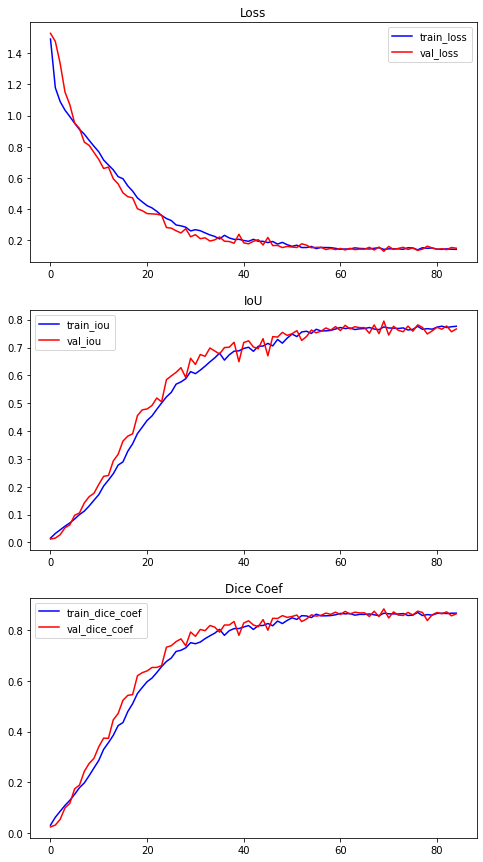

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 295 validated image filenames.
Found 295 validated image filenames.
18/18 [==============================] - 200s 11s/step - loss: 0.1658 - iou: 0.7291 - dice_coef: 0.8294
Test IOU:  0.7290715575218201
Test Dice Coefficent:  0.8294110298156738


In [ ]:
history.model.save_weights("/content/drive/MyDrive/kaggle_3m/model2.h5")
model_json = history.model.to_json()
with open("/content/drive/MyDrive/kaggle_3m/model2.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/kaggle_3m/model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
clf = model_from_json(loaded_model_json)
clf.load_weights("/content/drive/MyDrive/kaggle_3m/model2.h5")

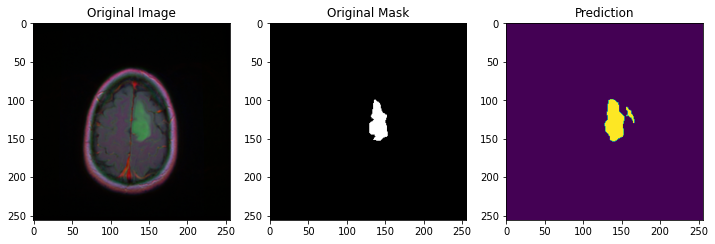

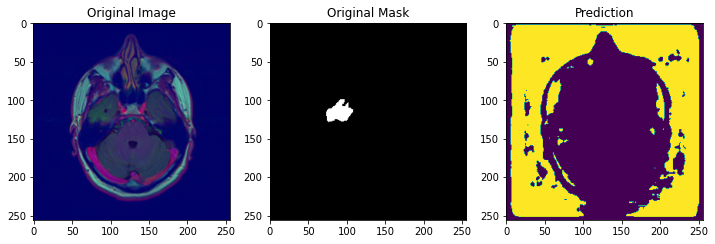

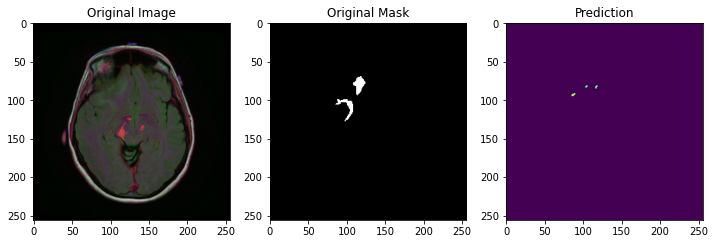

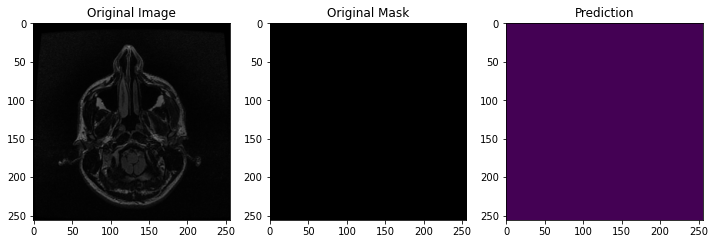

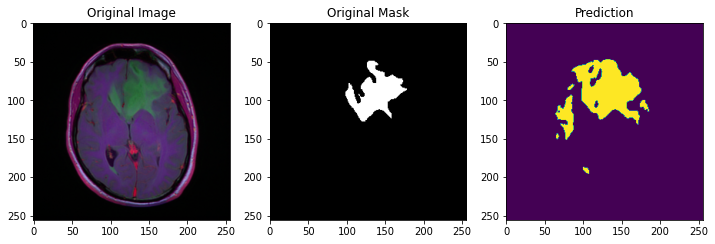

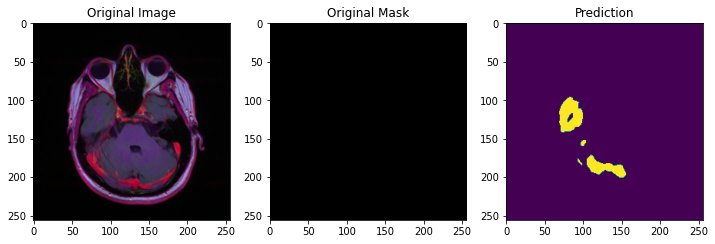

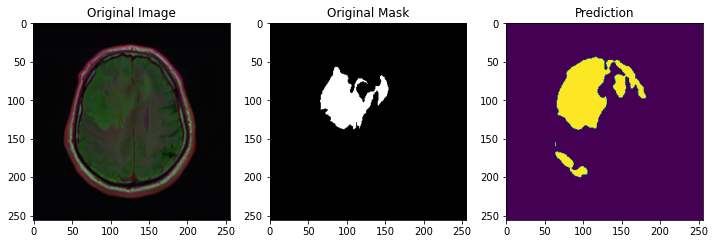

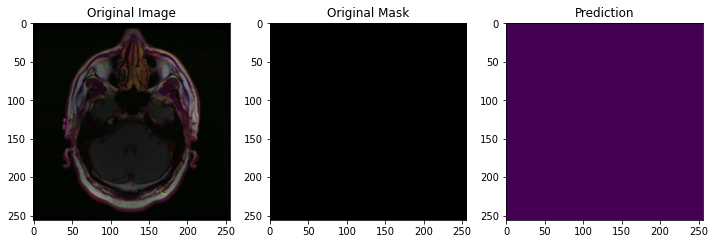

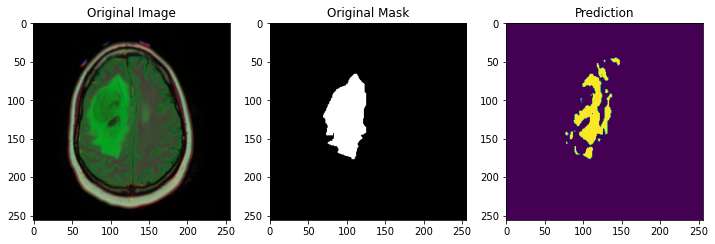

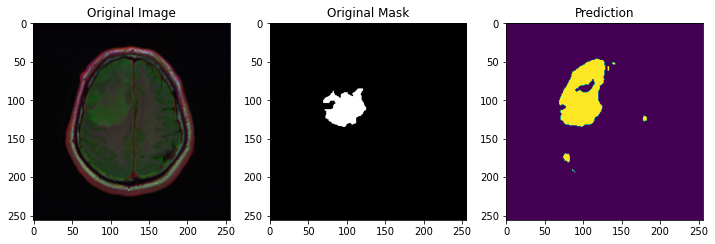

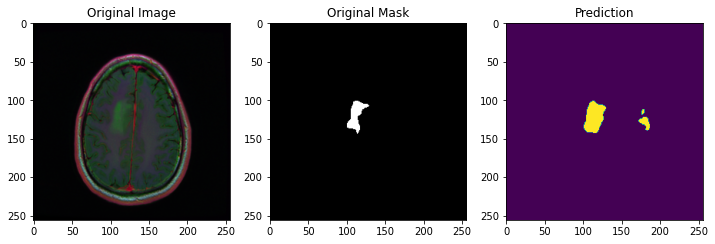

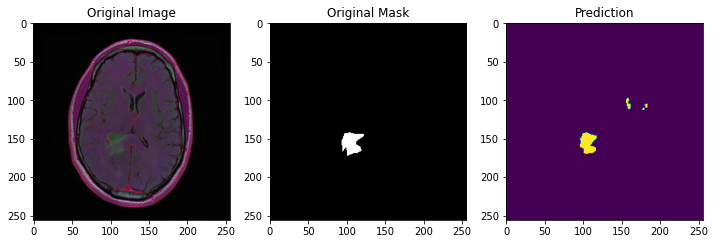

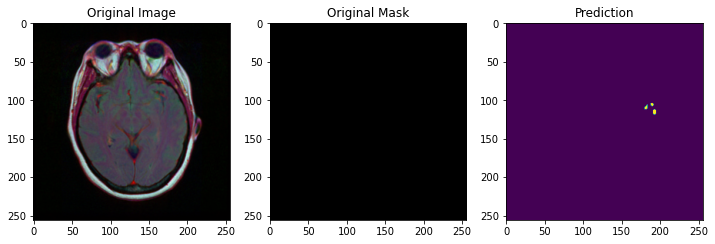

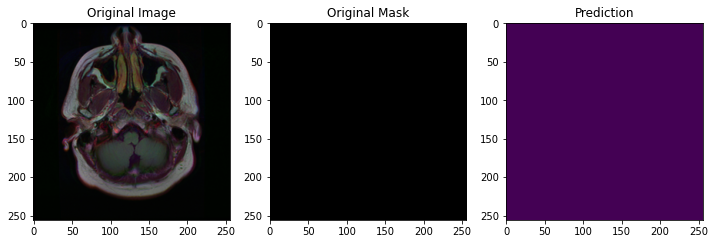

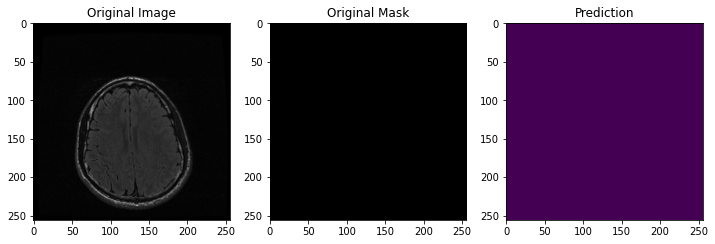

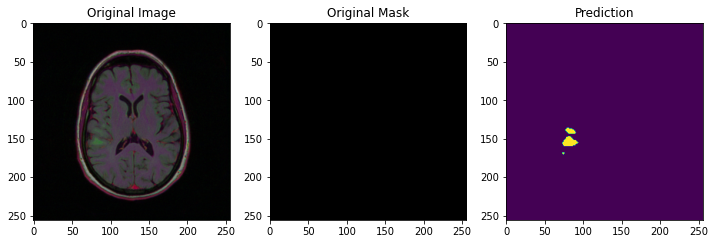

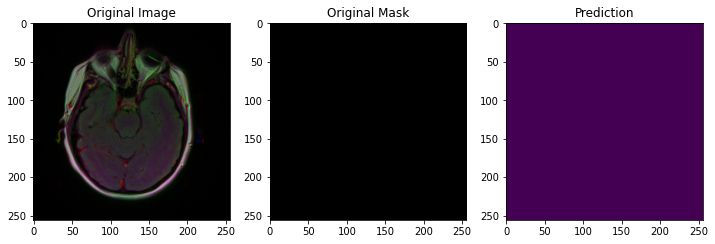

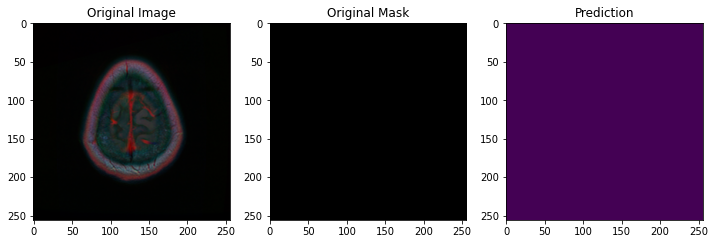

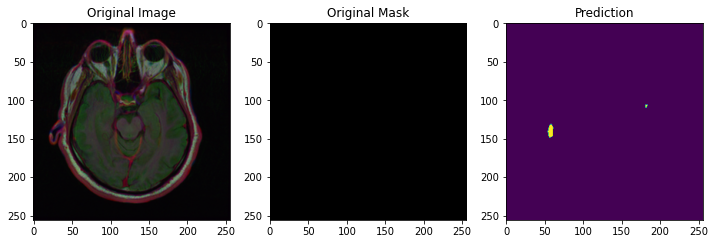

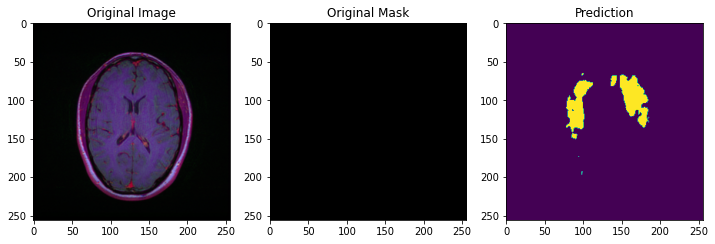

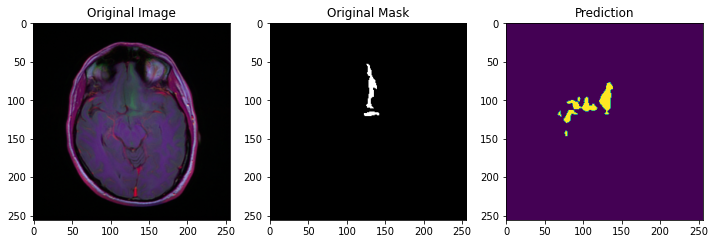

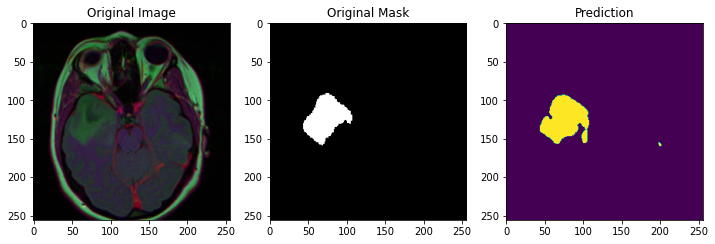

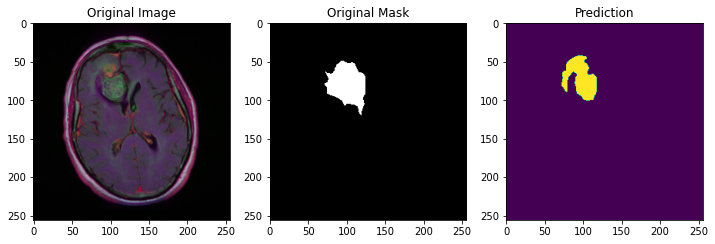

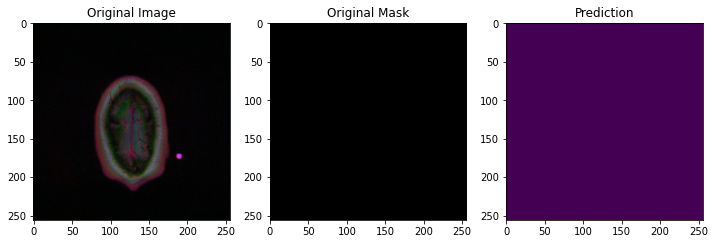

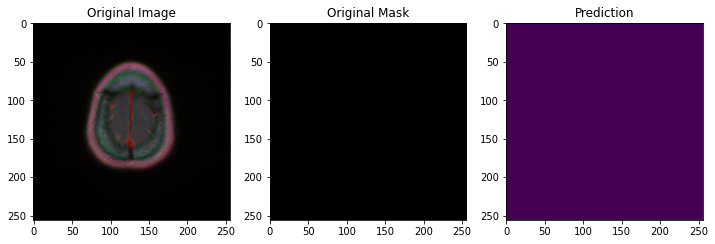

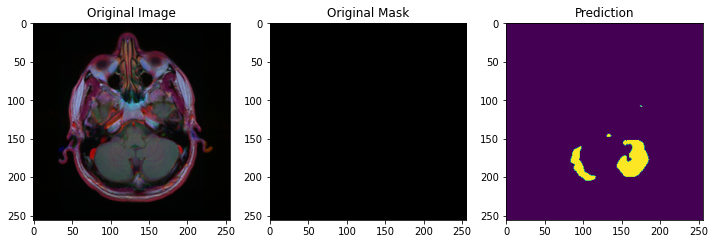

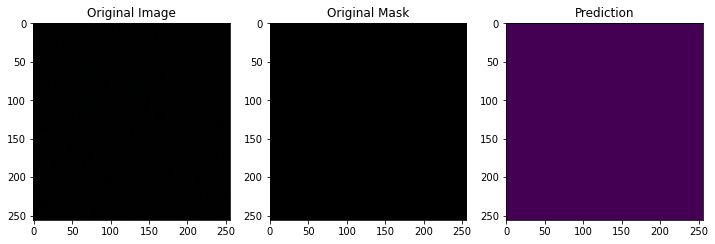

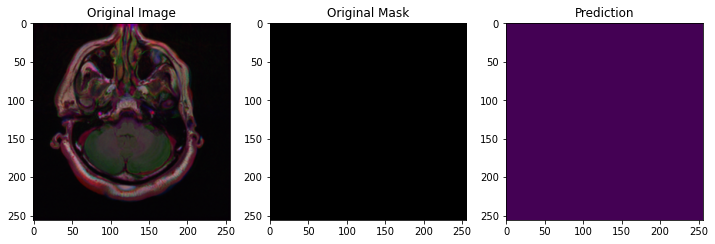

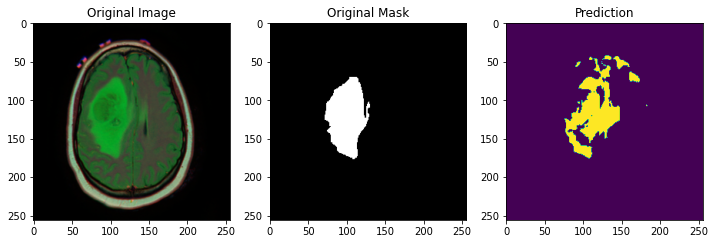

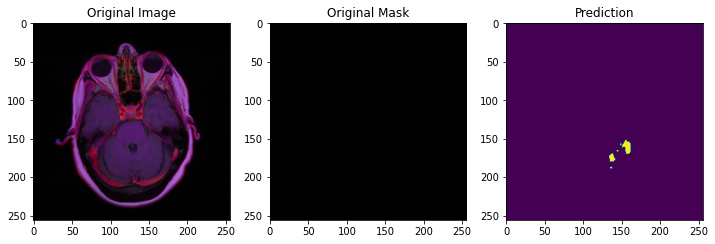

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=clf.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()